In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel

from scipy.spatial.distance import cdist
from skdim.id import MLE

from tqdm import tqdm

# Computations of Intrinsic dimension for shorter texts are unstable and we want to avoid them;
MINIMAL_STABLE_LENGTH = 47

In [2]:
model_path = 'FacebookAI/roberta-base'
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaModel.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
### Multilingual case
model_path = '.../xlm-base'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

In [4]:
def prim_tree(adj_matrix, power=1.0):
    infty = np.max(adj_matrix) + 1.0
    
    dst = np.ones(adj_matrix.shape[0]) * infty
    visited = np.zeros(adj_matrix.shape[0], dtype=bool)
    ancestor = -np.ones(adj_matrix.shape[0], dtype=int)

    v, s = 0, 0.0
    for i in range(adj_matrix.shape[0] - 1):
        visited[v] = 1
        ancestor[dst > adj_matrix[v]] = v
        dst = np.minimum(dst, adj_matrix[v])
        dst[visited] = infty
        
        v = np.argmin(dst)
        
        s += adj_matrix[v][ancestor[v]] ** power
    return s.item()

def sample_W(W, nSamples, isRandom=True):
    n = W.shape[0]
    random_indices = np.random.choice(n, size=nSamples, replace=False)
    return W[random_indices]

def calculate_ph_dim(W, min_points=40, max_points=510, point_jump=20, alpha=1.0, restarts=3, resamples=7):
    # Computations for shorter texts are unstable and we want to avoid them
    if W.shape[0] < MINIMAL_STABLE_LENGTH: 
        return np.nan
    
    m_candidates = []
    for i in range(restarts): 
        test_n = range(min_points, max_points, point_jump)
        lengths = []

        for n in test_n:
            reruns = np.ones(resamples)
            for i in range(resamples):
                tmp = sample_W(W, n)
                reruns[i] = prim_tree(cdist(tmp, tmp), power=alpha)
            lengths.append(np.median(reruns))

        lengths = np.array(lengths)
        x = np.log(np.array(list(test_n)))
        y = np.log(lengths)

        N = len(x)
        m_candidates.append((N * (x * y).sum() - x.sum() * y.sum()) / (N * (x ** 2).sum() - x.sum() ** 2))
    m = np.mean(m_candidates)
    return alpha / (1 - m)

In [5]:
'''
Get CLS-tokens for all texts in df[key] Pandas DataSeries (RoBERTa-CLS baseline)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
Returns:
    numpy.array of shape (number_of_texts, size_of_embedding=768)
'''

def get_cls(df, key='text', is_list=False):
    dims = np.zeros((len(df[key]),768))
    cnt = 0
    for text in tqdm(df[key]):
        if is_list:
            s = text[0]
        else:
            s = text
        inputs = tokenizer(s.replace('\n', ' '), truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outp = model(**inputs)
        dims[cnt] = outp[0][0].numpy()[0]
        cnt += 1
    return dims

In [6]:
'''
Get MLE for one text
Parameters:
        text  --- text
Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Maximum Likelihood Estimation method.'''

def get_mle_single(text):
    inputs = tokenizer(text.replace('\n', ' '), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)
    mx_points = inputs['input_ids'].shape[1] - 2
        
    # Computations for shorter texts are unstable and we want to avoid them
    if mx_points < MINIMAL_STABLE_LENGTH:     
        return np.nan
            
    return MLE().fit_transform(outp[0][0].numpy()[1:-1])

'''
Get MLE for all texts in df[key] Pandas DataSeries (MLE method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Maximum Likelihood Estimation method.
'''

def get_mle(df, key='text', is_list=False):
    dims = []
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
            
        dims.append(get_mle_single(text))
    return np.array(dims).reshape(-1, 1)

In [7]:
'''
Get PHD for one text
Parameters:
        text  --- text
        alpha --- Parameter alpha for PHD computattion

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Persistence Homology Dimension method.'''
def get_phd_single(text, alpha=1.0):
    inputs = tokenizer(text.replace('\n', ' '), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)
        
    mx_points = inputs['input_ids'].shape[1] - 2        
    mn_points = 40
    step = ( mx_points - mn_points ) // 7
        
    return calculate_ph_dim(outp[0][0].numpy()[1:-1],  min_points=mn_points, max_points=mx_points, \
                                     point_jump=step, alpha=alpha)

'''
Get PHD for all texts in df[key] Pandas DataSeries (PHD method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
        alpha --- Parameter alpha for PHD computattion

Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Persistence Homology Dimension method.
'''

def get_phd(df, key='text', is_list=False, alpha=1.0):
    dims = []
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
        dims.append(get_phd_single(text, alpha=alpha))

    return np.array(dims).reshape(-1, 1)

# An example

### RoBERTa-CLS baseline

In [ ]:
'''
train_idx, valid_idx, test_idx are indexes of train/validation/evaluation splits
'''

In [ ]:
reddit_data = pd.read_json(".../Datasets/opt_13b_reddit.jsonl_pp", lines=True)

#Training subset
human_cls_train_en = get_cls(reddit_data.iloc[train_idx], 'gold_completion')
opt_cls_train_en = get_cls(reddit_data.iloc[train_idx], 'gen_completion',is_list=True)

#Validation subset
human_cls_dev_en = get_cls(reddit_data.iloc[valid_idx], 'gold_completion')
opt_cls_dev_en = get_cls(reddit_data.iloc[valid_idx], 'gen_completion',real=False)

#Evaluation subset
human_cls_test_en = get_cls(reddit_data.iloc[test_idx], 'gold_completion')
opt_cls_test_en =  get_cls(reddit_data.iloc[test_idx], 'gen_completion',real=False)

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train = np.vstack([human_cls_train_en, opt_cls_train_en])
X_valid = np.vstack([human_cls_dev_en, opt_cls_dev_en])

y_train = np.hstack([np.ones(len(human_cls_train_en)), np.zeros(len(opt_cls_train_en))])
y_valid = np.hstack([np.ones(len(human_cls_dev_en)), np.zeros(len(opt_cls_dev_en))])

cls = LogisticRegression(penalty='l1', solver='liblinear',  C=100, max_iter=1000).fit(X_train, y_train)

print('Train acc.: ', cls.score(X_train, y_train))
print('Validation acc.: ', cls.score(X_valid, y_valid))

In [ ]:
X_test = np.vstack([human_cls_test_en, opt_cls_test_en])
y_test = np.hstack([np.ones(len(human_cls_test_en)), np.zeros(len(opt_cls_test_en))])

print('Test acc.: ', cls.score(X_test, y_test))

### MLE

In [16]:
sample_text = "Speaking of festivities, there is one day in China that stands unrivaled - the first day of the Lunar New Year, commonly referred to as the Spring Festival. Even if you're generally uninterested in celebratory events, it's hard to resist the allure of the family reunion dinner, a quintessential aspect of the Spring Festival. Throughout the meal, family members raise their glasses to toast one another, expressing wishes for happiness, peace, health, and prosperity in the upcoming year."

In [20]:
print("MLE estimation of the Intrinsic dimension of sample text is ", get_mle_single(sample_text))

MLE estimation of the Intrinsic dimension of sample text is  11.54934897385235


In [ ]:
reddit_data = pd.read_json(".../Datasets/opt_13b_reddit.jsonl_pp", lines=True)

#Training subset
human_mle_train_en = get_mle(reddit_data.iloc[train_idx], 'gold_completion')
opt_mle_train_en = get_mle(reddit_data.iloc[train_idx], 'gen_completion',is_list=True)


### PHD

In [10]:
sample_text = "Speaking of festivities, there is one day in China that stands unrivaled - the first day of the Lunar New Year, commonly referred to as the Spring Festival. Even if you're generally uninterested in celebratory events, it's hard to resist the allure of the family reunion dinner, a quintessential aspect of the Spring Festival. Throughout the meal, family members raise their glasses to toast one another, expressing wishes for happiness, peace, health, and prosperity in the upcoming year."

In [11]:
print("PHD estimation of the Intrinsic dimension of sample text is ", get_phd_single(sample_text))

PHD estimation of the Intrinsic dimension of sample text is  8.898211825857993


In [19]:
#Training subset

reddit_data = pd.read_json("../semeval_data/subtaskC_train.jsonl", lines=True)

# human_phd_train_en = get_phd(reddit_data.iloc[:1000])

100%|██████████| 1000/1000 [28:21<00:00,  1.70s/it]


In [55]:
data = pd.read_csv('../datasets/iberautex24.csv')
data = data.dropna()
data

,text,lang,label
0,The former smiths frontman had postponed 14 da...,en,0
1,Fompedriña é un lugar da parroquia de cela no ...,gl,0
2,"En la antesala, durante más de un mes, compart...",es,0
3,Mientras realizaban aquella truculenta operaci...,es,0
4,"Cuando tú registras tu salida, pagas la cuenta...",es,0
...,...,...,...
995,A mellor para un día de resaca que unha boa ch...,gl,1
996,Título: novembro de 2021: un mes repleto de ac...,gl,1
997,Xabier letek bere poesia errezitaldi berezia e...,eu,1
998,"Pin hauetat iritsua astian, euskal herria. 199...",eu,1


In [57]:
human_iber = get_phd(data.iloc[:500], key='text')

100%|██████████| 500/500 [15:20<00:00,  1.84s/it]


In [58]:
machine_iber = get_phd(data.iloc[500:], key='text')

100%|██████████| 500/500 [15:32<00:00,  1.87s/it]


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phds(humans, machines, name):
    # Replace these with your actual data
    human = [x[0] for x in humans]  # Intrinsic dimensions for natural texts
    machine = [x[0] for x in machines]      # Intrinsic dimensions for GPT-3.5

    # Prepare the data in the format required for Seaborn
    data = {
        "Model": ["Human"] * len(human) + ["Generated"] * len(machine),
        "Intrinsic Dimension": human + machine
    }
    
    combined = np.array(human + machine)

    df = pd.DataFrame({"PHD": combined})
    df.to_csv(f'{name}_phd.csv')

    # Initialize the plot
    plt.figure(figsize=(10, 2))
    sns.set(style="whitegrid")

    # Create a boxplot
    sns.boxplot(y="Model", x="Intrinsic Dimension", data=data, palette=["skyblue", "indianred"])

    # Customize the plot
    plt.title(f"PHD {name}", fontsize=14)
    plt.xlabel("")
    plt.xlim(0, 15)
    # plt.ylabel("Intrinsic Dimension", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    # Show the plot
    plt.savefig(f'pics/{name}.png')
    plt.show()

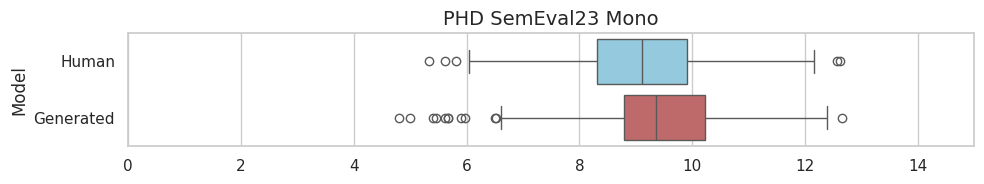

In [125]:

plot_phds(human_semeval, machine_semeval, 'SemEval23 Mono')


In [273]:
semeval_en = pd.read_csv('SemEval23 Mono_phd.csv', index_col=[0])

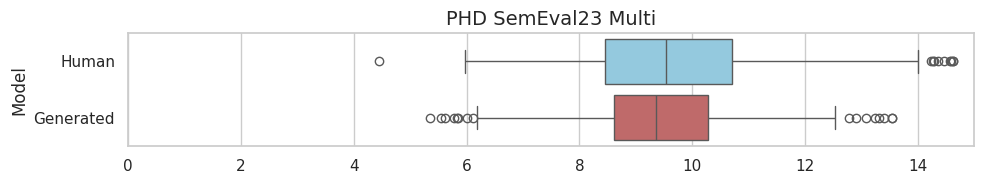

In [52]:

plot_phds(human_semevalmulti, machine_semevalmulti, 'SemEval23 Multi')

In [274]:
semeval_multi = pd.read_csv('SemEval23 Multi_phd.csv', index_col=[0])

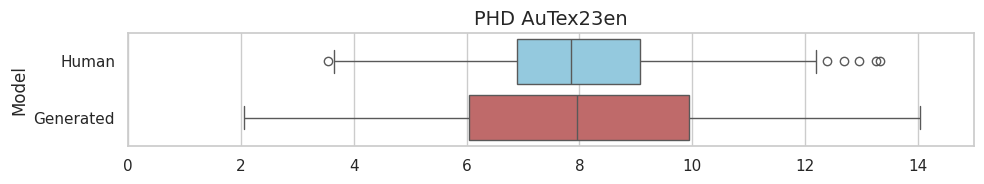

In [126]:
plot_phds(human_autexen, machine_autexen, 'AuTex23en')


In [276]:
autex23en = pd.read_csv('AuTex23en_phd.csv', index_col=[0])

In [277]:
autex23es = pd.read_csv('AuTex23es_phd.csv', index_col=[0])

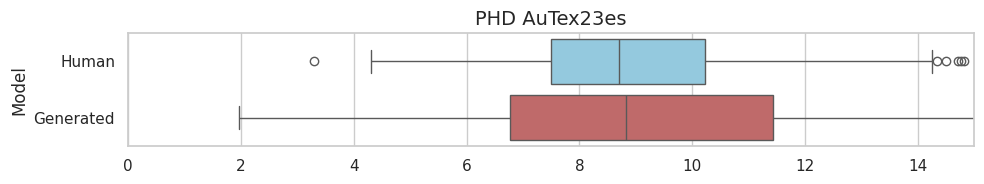

In [127]:
plot_phds(human_autexes, machine_autexes, 'AuTex23es')


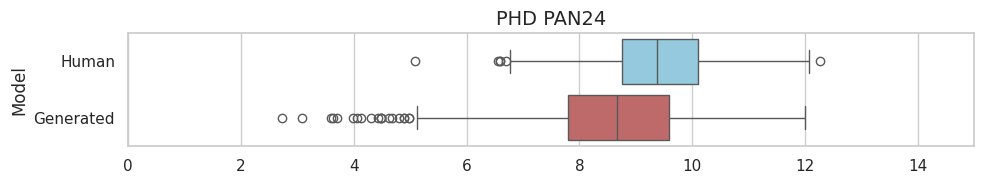

In [128]:
plot_phds(human_pan, machine_pan, 'PAN24')


In [278]:
pan = pd.read_csv('PAN24_phd.csv', index_col=[0])

In [279]:
iber = pd.read_csv('IberAuTex_phd.csv', index_col=[0])

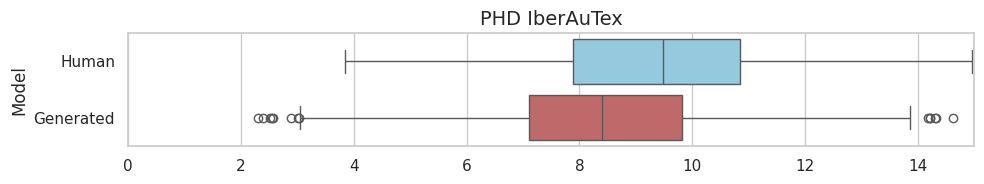

In [59]:
plot_phds(human_iber, machine_iber, 'IberAuTex')


In [282]:
coling_en = pd.read_csv('MGT-1 Mono_phd.csv', index_col=[0])
coling_multi = pd.read_csv('MGT-1 Multi_phd.csv', index_col=[0])

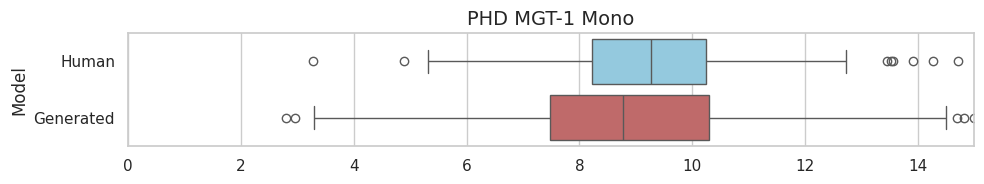

In [129]:
plot_phds(human_colingen, machine_colingen, 'MGT-1 Mono')

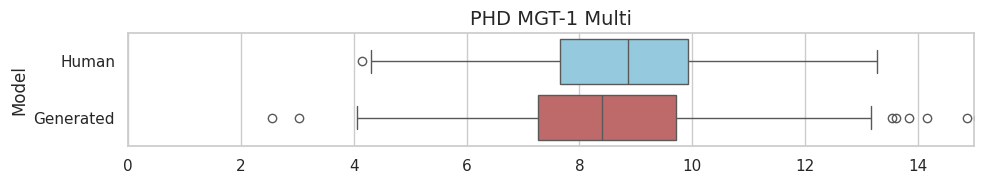

In [133]:
plot_phds(human_colingmulti, machine_colingmulti, 'MGT-1 Multi')

In [283]:
ruatd = pd.read_csv('RuATD_phd.csv', index_col=[0])

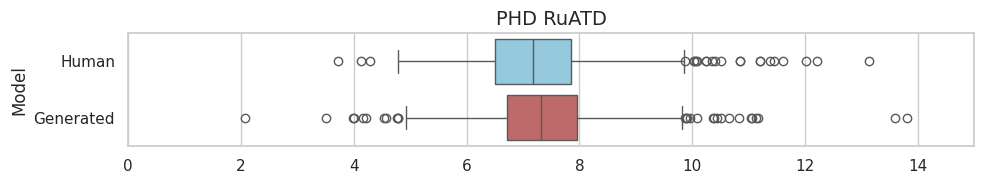

In [137]:
plot_phds(human_ruatd, machine_ruatd, 'RuATD')

In [284]:
tweepfake = pd.read_csv('TweepFake_phd.csv', index_col=[0])

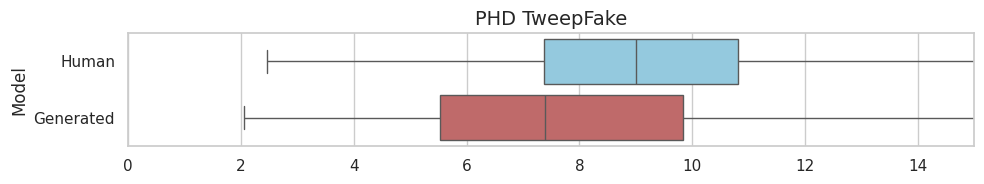

In [41]:
plot_phds(human_tweep, machine_tweep, 'TweepFake')

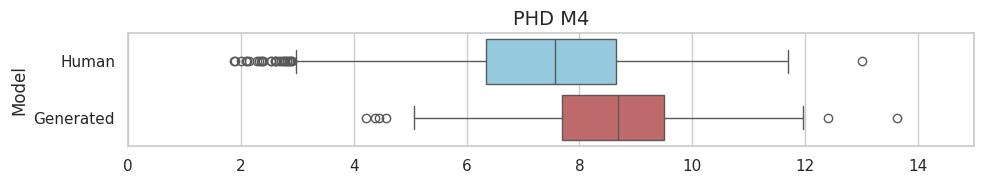

In [150]:
plot_phds(human_m4, machine_m4, 'M4')

In [287]:
m4 = pd.read_csv('M4_phd.csv', index_col=[0])
gpt2 = pd.read_csv('GPT2_phd.csv', index_col=[0])

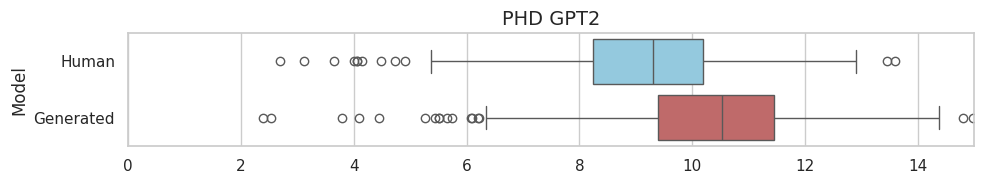

In [13]:
plot_phds(human_gpt2, machine_gpt2, 'GPT2')

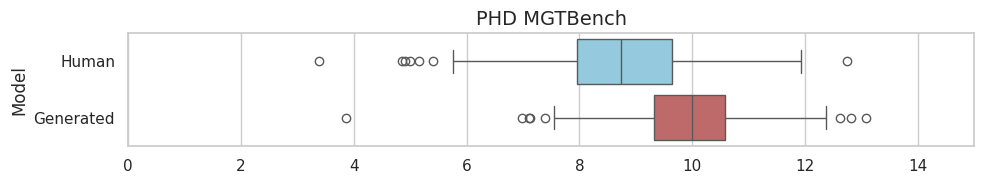

In [25]:
plot_phds(human_mgt, machine_mgt, 'MGTBench')

In [288]:
mgt = pd.read_csv('MGTBench_phd.csv', index_col=[0])

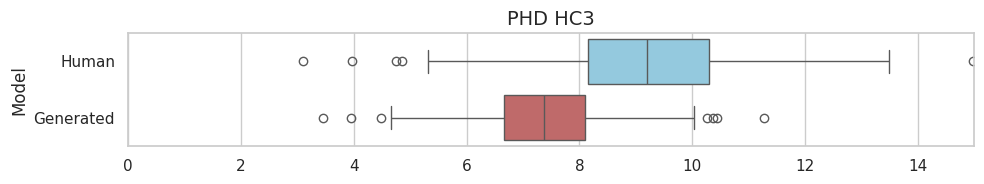

In [26]:
plot_phds(human_hc3, machine_hc3, 'HC3')

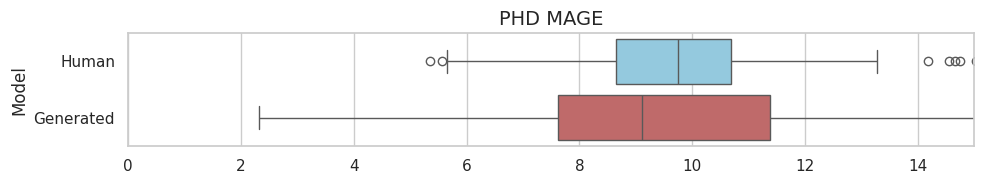

In [36]:
plot_phds(human_mage, machine_mage, 'MAGE')

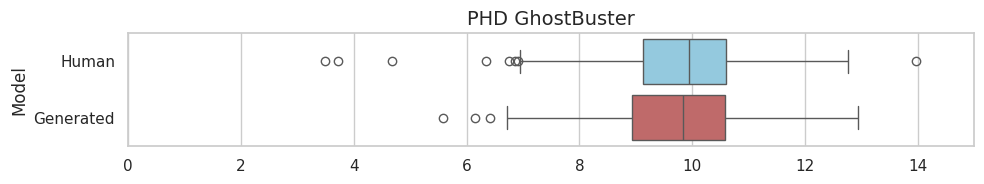

In [37]:
plot_phds(human_ghost, machine_ghost, 'GhostBuster')

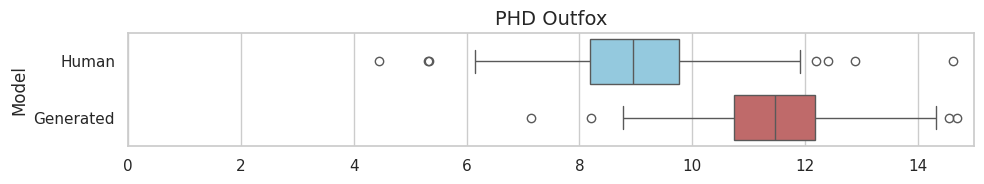

In [45]:
plot_phds(human_outfox, machine_outfox, 'Outfox')

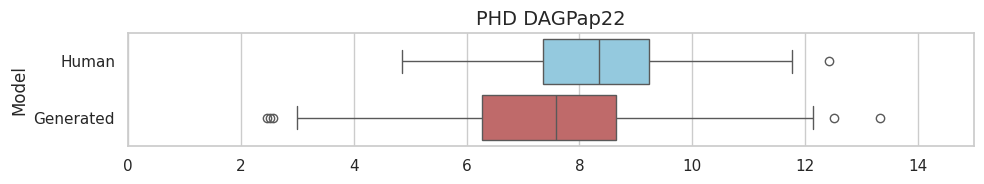

In [336]:
plot_phds(human_dagpap, machine_dagpap, 'DAGPap22')

In [487]:
t = [*human_hc3, *machine_hc3]
hc3 = [x[0] for x in t]

In [364]:
def generate_data(arrays, labels):
    scores = []
    model = []
    final_labels = []
    # print(len(arrays))
    for x, label in zip(arrays, labels):
        if type(x[0]) is  not np.float64:
            # print(type(x[0]))
            new_x = [t[0] for t in x]
            scores.extend(new_x)
        else:
            scores.extend(x)
        model += ['Human'] * 500 + ['Generated'] * 500
        final_labels += [label] * 1000 
    return {
        'Score': scores,
        'Model': model,
        'Case': final_labels
    }


In [380]:
m4.loc[980] = hc3[4]

In [455]:
cur_arr = autex23es

cur_arr = np.array(cur_arr)
cur_arr = cur_arr[~np.isnan(cur_arr)]

values = cur_arr[:500]

mean = np.mean(values)

# Calculate the standard deviation
std_dev = np.std(values)#.values[0]

print(f"{round(mean, 2)} + {round(std_dev, 2)} &", end=' ')

values = cur_arr[500:]

mean = np.mean(values)

# Calculate the standard deviation
std_dev = np.std(values)#.values[0]

print(f"{round(mean, 2)} + {round(std_dev, 2)}")

9.02 + 3.19 & 8.12 + 4.02


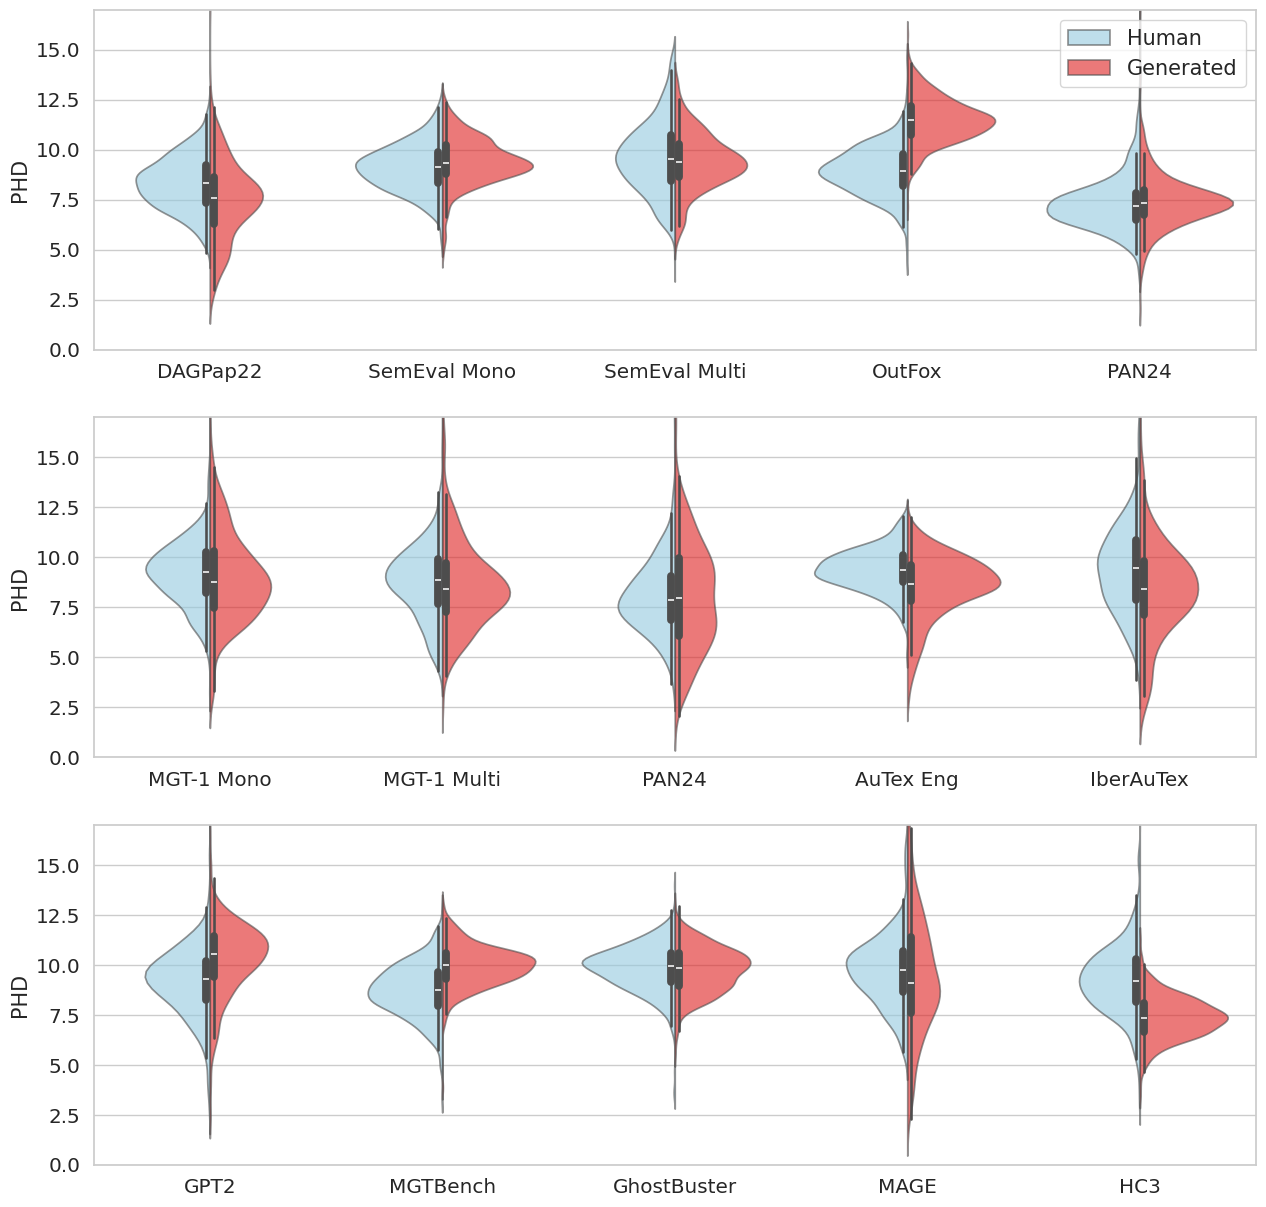

In [494]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig, axes = plt.subplots(3, 1, figsize=(15,15), sharey=True)
values1 = [dagpap, semeval_en.values, semeval_multi.values, outfox, ruatd.values]
labels1 = ['DAGPap22', 'SemEval Mono', 'SemEval Multi', 'OutFox', 'PAN24']

values2 = [coling_en.values, coling_multi.values, autex23en.values, pan.values, iber.values]
labels2 = ['MGT-1 Mono', 'MGT-1 Multi', 'PAN24', 'AuTex Eng', 'IberAuTex']


values3 = [gpt2.values, mgt.values, ghost, mage, hc3]
labels3 = ['GPT2', 'MGTBench', 'GhostBuster', 'MAGE', 'HC3']

for i, ax in zip(range(3), axes.flatten()):
    # sns.boxplot(y=name, x= "a", data=df, orient='v', ax=ax)
    if i == 0:
        # continue
        data = generate_data(values1, labels1)
    elif i == 1:
        # continue
        data = generate_data(values2, labels2)
    elif i == 2:
        data = generate_data(values3, labels3)
    # print(data)
    df = pd.DataFrame(data)
    g = sns.violinplot(data=df, x='Case', y='Score', hue='Model', split=True, palette=['skyblue', 'red'], alpha=0.6, ax=ax)
    if i != 0:
        axes[i].legend([],[], frameon=False)
    else:
        g.legend(fontsize=15)
    # axes[i].set_title(f'PHD' if i == 0 else '')   # Title for each subplot
    axes[i].set_xlabel('', fontsize=15) 
    axes[i].set_ylabel('PHD', fontsize=15) 
    axes[i].set_ylim(0, 17)

# plt.ylim(0,17)
# # Add labels and title
# plt.title('Combined PHD Violin Plots')
# plt.xlabel('Cases')
# plt.ylabel('PHD')
# plt.legend(title='Model', loc='upper left')

# Show the plot
plt.savefig('violins_v1.png')
plt.show()


In [404]:
import matplotlib.pylab as pylab
value = 'large'
params = {'legend.fontsize': value,
         'axes.labelsize':  value,
         'axes.titlesize':value,
         'xtick.labelsize':value,
         'ytick.labelsize':value}
pylab.rcParams.update(params)

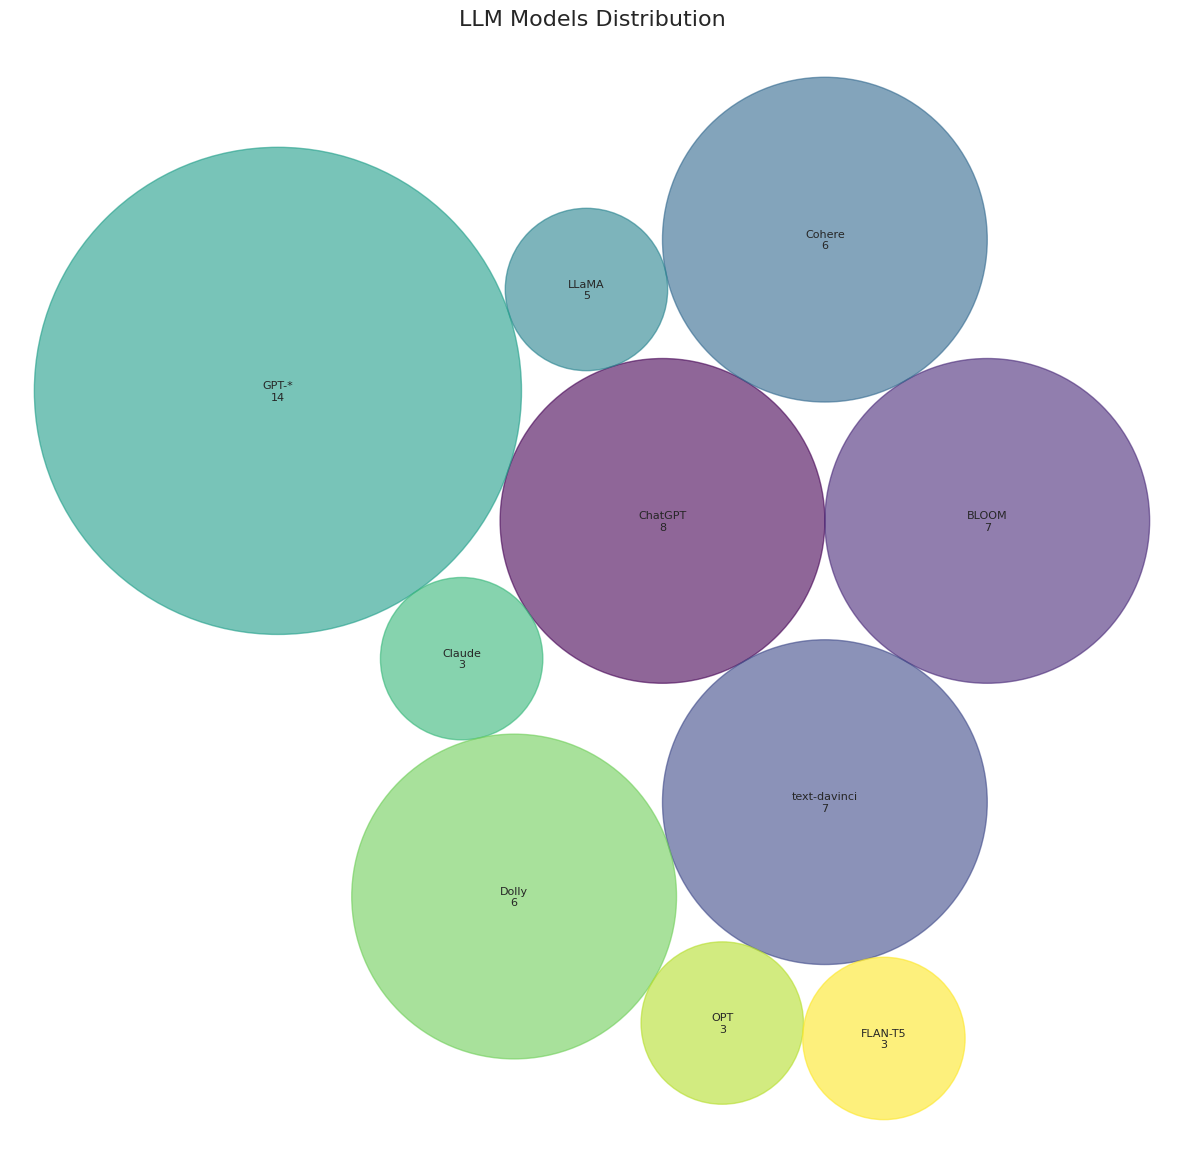

In [166]:
import matplotlib.pyplot as plt
import numpy as np
import packcircles

# Generate circle packing layout
circles = packcircles.pack(radii)
x, y, r = np.array([(circle[0], circle[1], circle[2]) for circle in circles]).T

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Radius and coordinate adjustment factors
radius_factor = 0.8  # Adjust this to change the circle sizes
coordinate_scale = 0.8  # Adjust this to bring circles closer

# Create bubbles
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
for i in range(len(labels)):
    # Apply radius adjustment and coordinate scaling
    circle = plt.Circle((x[i] * coordinate_scale, y[i] * coordinate_scale), 
                        r[i] * radius_factor, 
                        alpha=0.6, 
                        color=colors[i])
    ax.add_patch(circle)
    
    # Add labels
    plt.annotate(f"{labels[i]}\n{values[i]}",
                (x[i] * coordinate_scale, y[i] * coordinate_scale),
                ha='center',
                va='center',
                fontsize=8)

# Set equal aspect ratio and remove axes
ax.set_aspect('equal')
ax.axis('off')

# Set the limits with some padding
padding = max(r) * radius_factor * 0.1
plt.xlim(min(x * coordinate_scale - r*radius_factor) - padding, 
         max(x * coordinate_scale + r*radius_factor) + padding)
plt.ylim(min(y * coordinate_scale - r*radius_factor) - padding, 
         max(y * coordinate_scale + r*radius_factor) + padding)

plt.title('LLM Models Distribution', fontsize=16, pad=20)
plt.tight_layout()
plt.show()